In [1]:
import datetime
import tensorflow as tf
import itertools
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error as mae
import random
import math
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
from xgboost import plot_importance
import optuna
import plotly.graph_objects as go
import plotly.figure_factory as ff
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

2021-10-07 11:52:59.104001: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-07 11:52:59.104133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Helpful functions

In [2]:
def pori(r):
    if(r=='March'):
        return '1'
    if(r=='June'):
        return '2'
    if(r=='September'):
        return '3'
    if(r=='December'):
        return '4'
    
    
def plot_time(what,data):
    fig, ax=plt.subplots(figsize=(25,10))
    sns.lineplot(data=data, x="Year", y=what, hue="Period",estimator=np.mean)
    ax.set_title(what+' variation over years')
    plt.xticks(rotation=45)
    plt.yticks(rotation=90)
    plt.show()
    
def remove_deg(r):
    r=r.split('°')[0]
    s=r[1:]
    s=float(s)
    if(r[0]=='–'):
        s=s*-1
    return s  

def add_locations(r,s):
    for i in list(r['Area'].unique()):
        a=i.strip()
        if(a=='DeWitt'):
            a='De Witt'  
        r.loc[r.Area == i, 'FIPS'] = s[s['CNTY_NM']==a]['FIPS'].values[0]
    return r
    

In [3]:
!pip3 install openpyxl

     |████████████████████████████████| 242 kB 513 kB/s eta 0:00:01


In [4]:
df=pd.read_excel('../input/data23/Tx_LaborStats_2005-2021.xlsx')
df.head()

,Year,Period,Area,Area Type,Adjustment,Employment,Civilian Labor Force,Unemployment,Unemployment Rate
0,2005,March,Texas,Texas,Not Adjusted,10457456,11066337,608881,5.5
1,2005,March,Texas,Texas,Adjusted,10502785,11125846,623061,5.6
2,2005,June,Texas,Texas,Not Adjusted,10557049,11181612,624563,5.6
3,2005,June,Texas,Texas,Adjusted,10569961,11163389,593428,5.3
4,2005,September,Texas,Texas,Not Adjusted,10589753,11216770,627017,5.6


In [5]:
tx=df[df['Area Type']=='Texas'] # dataset with Area Type as Texas
tx=tx.reset_index(drop=True)

In [6]:
county=df[df['Area Type']=='County'] # dataset with Area Type county
county=county.reset_index(drop=True)

# EDA Part

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16896 entries, 0 to 16895
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  16896 non-null  int64  
 1   Period                16896 non-null  object 
 2   Area                  16896 non-null  object 
 3   Area Type             16896 non-null  object 
 4   Adjustment            16896 non-null  object 
 5   Employment            16896 non-null  int64  
 6   Civilian Labor Force  16896 non-null  int64  
 7   Unemployment          16896 non-null  int64  
 8   Unemployment Rate     16896 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.2+ MB


In [8]:
county=county.drop(['Area Type'],axis=1)
tx=tx.drop(['Area Type'],axis=1)

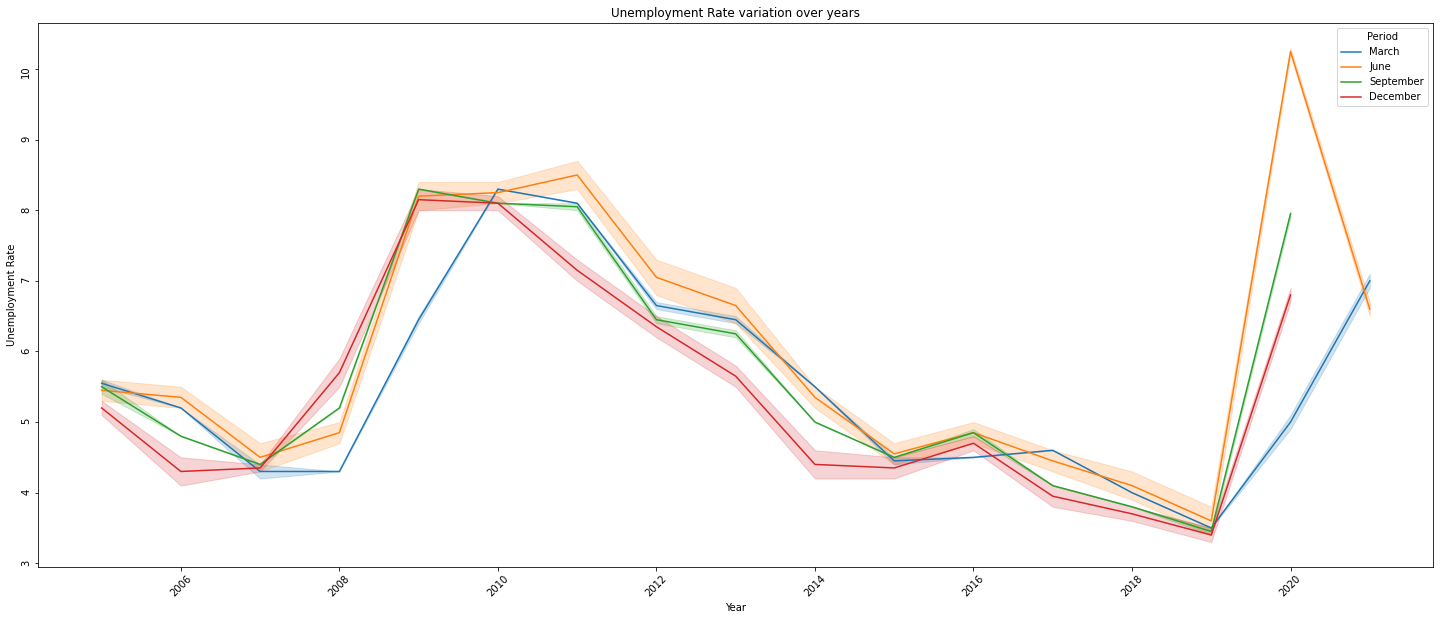

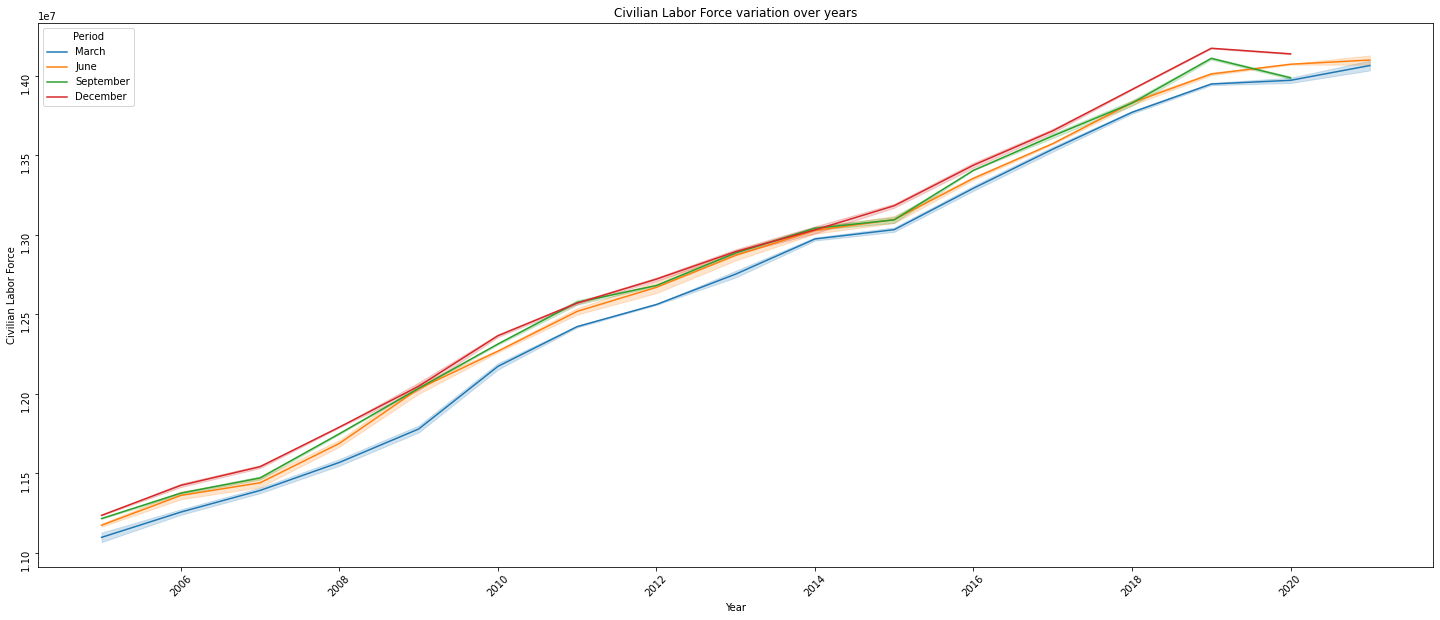

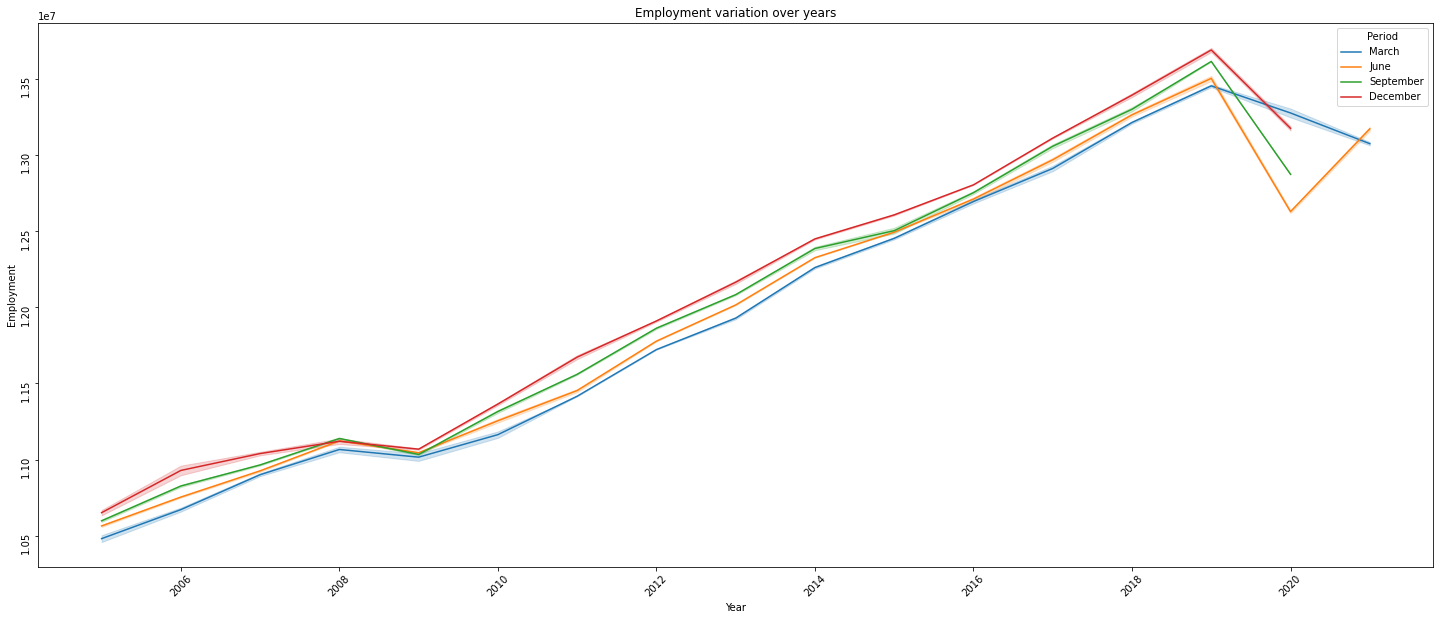

In [9]:
plot_time('Unemployment Rate',tx)
plot_time('Civilian Labor Force',tx)
plot_time('Employment',tx)

In [10]:
features=['Employment','Civilian Labor Force','Unemployment','Unemployment Rate']
tx_variation=pd.DataFrame([i for i in range(2005,2022,1) for _ in range(2)],columns=['Year'])
li=['Not Adjusted', 'Adjusted']*(2022-2005)
tx_variation['Adjustment']=li
employment=[];civilian=[];unemployment=[];unemployment_rate=[]
for i in range(2005,2022):
    l=len(tx[(tx['Year']==i) & (tx['Adjustment']=='Not Adjusted')][features])
    r=tx[(tx['Year']==i) & (tx['Adjustment']=='Not Adjusted')][features].sum()/l
    employment.append(r[0]);civilian.append(r[1]);unemployment.append(r[2]);unemployment_rate.append(r[3])
    l=len(tx[(tx['Year']==i) & (tx['Adjustment']=='Adjusted')][features])
    r=tx[(tx['Year']==i) & (tx['Adjustment']=='Adjusted')][features].sum()/l
    employment.append(r[0]);civilian.append(r[1]);unemployment.append(r[2]);unemployment_rate.append(r[3])
tx_variation=tx_variation.assign(Employment=employment,Civilian_Labour_Force=civilian,Unemployment=unemployment,Unemployment_rate=unemployment_rate)

In [11]:
%%capture
tx['Extra']=tx['Period'].apply(lambda x:pori(x))
tx['Year_with_period']=tx['Year'].astype(str)+'-'+tx['Extra']
tx=tx.drop(['Extra','Period','Year'], axis=1)

In [12]:
tx.head()

,Area,Adjustment,Employment,Civilian Labor Force,Unemployment,Unemployment Rate,Year_with_period
0,Texas,Not Adjusted,10457456,11066337,608881,5.5,2005-1
1,Texas,Adjusted,10502785,11125846,623061,5.6,2005-1
2,Texas,Not Adjusted,10557049,11181612,624563,5.6,2005-2
3,Texas,Adjusted,10569961,11163389,593428,5.3,2005-2
4,Texas,Not Adjusted,10589753,11216770,627017,5.6,2005-3


In [13]:
tx_variation.head()

,Year,Adjustment,Employment,Civilian_Labour_Force,Unemployment,Unemployment_rate
0,2005,Not Adjusted,10568116.25,11175208.75,607092.50,5.450
1,2005,Adjusted,10577677.00,11183574.00,605897.00,5.400
2,2006,Not Adjusted,10798646.25,11355564.75,556918.50,4.900
3,2006,Adjusted,10790651.75,11350388.75,559737.00,4.925
4,2007,Not Adjusted,10960655.50,11467646.25,506990.75,4.400


**General Trend can be seen that 2nd Quarter has high unemployment rate while last quarter has the least**


**We can see clear spike in around 2008-2009 which was due to the great recession in US**

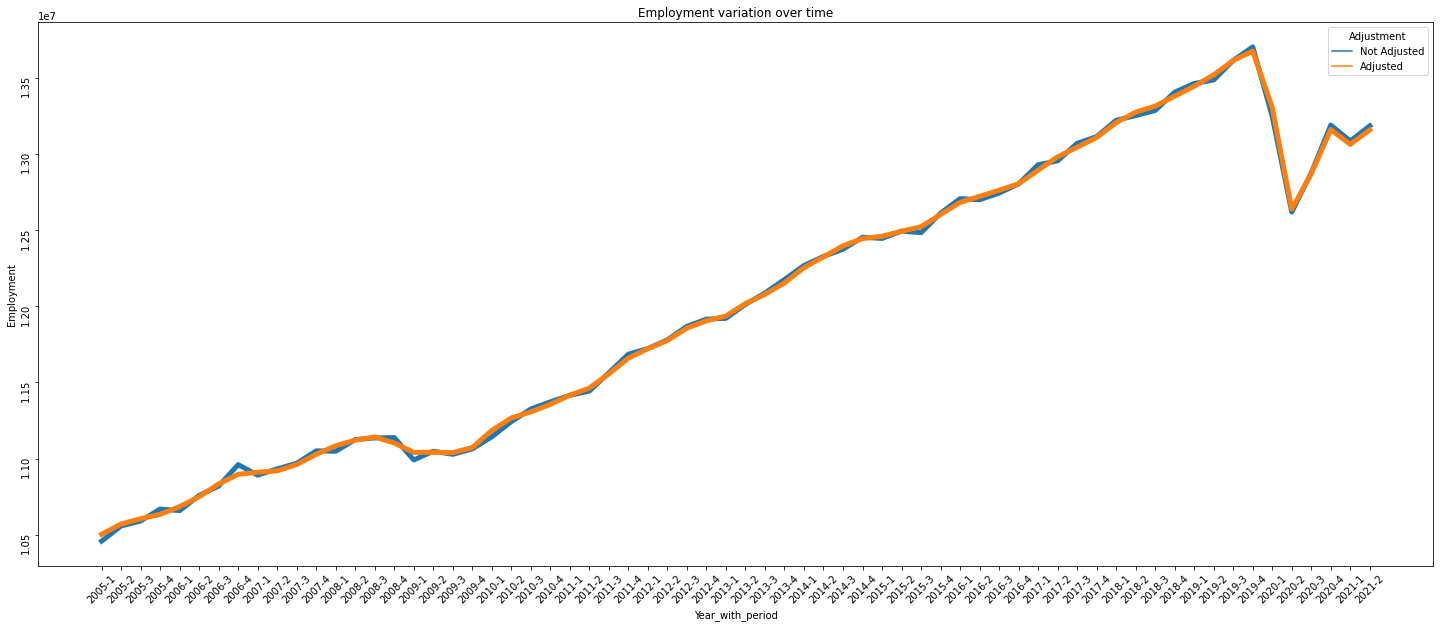

In [14]:
fig, ax=plt.subplots(figsize=(25,10))
sns.lineplot(data=tx, x="Year_with_period", y="Employment", hue='Adjustment',estimator=np.mean,linewidth=5)
ax.set_title('Employment variation over time')
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.show()

**Quaterly basis analysis will add noise as outliers will be in last one or two years too much**


**It can be seen employment rise over years except from 2020**

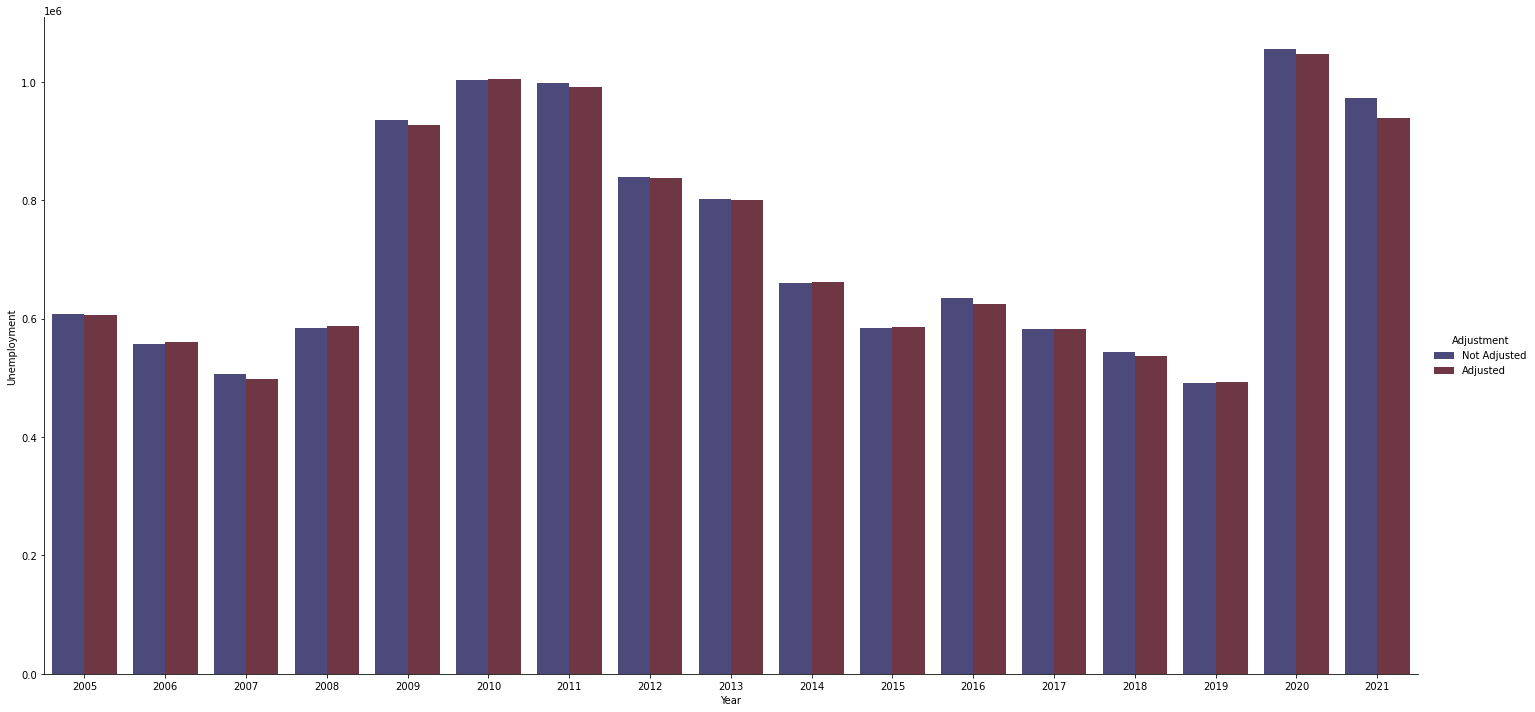

In [15]:
sns.catplot(x = 'Year', y = 'Unemployment', data = tx_variation, kind = 'bar', hue='Adjustment', height=10, aspect=2,palette='icefire')

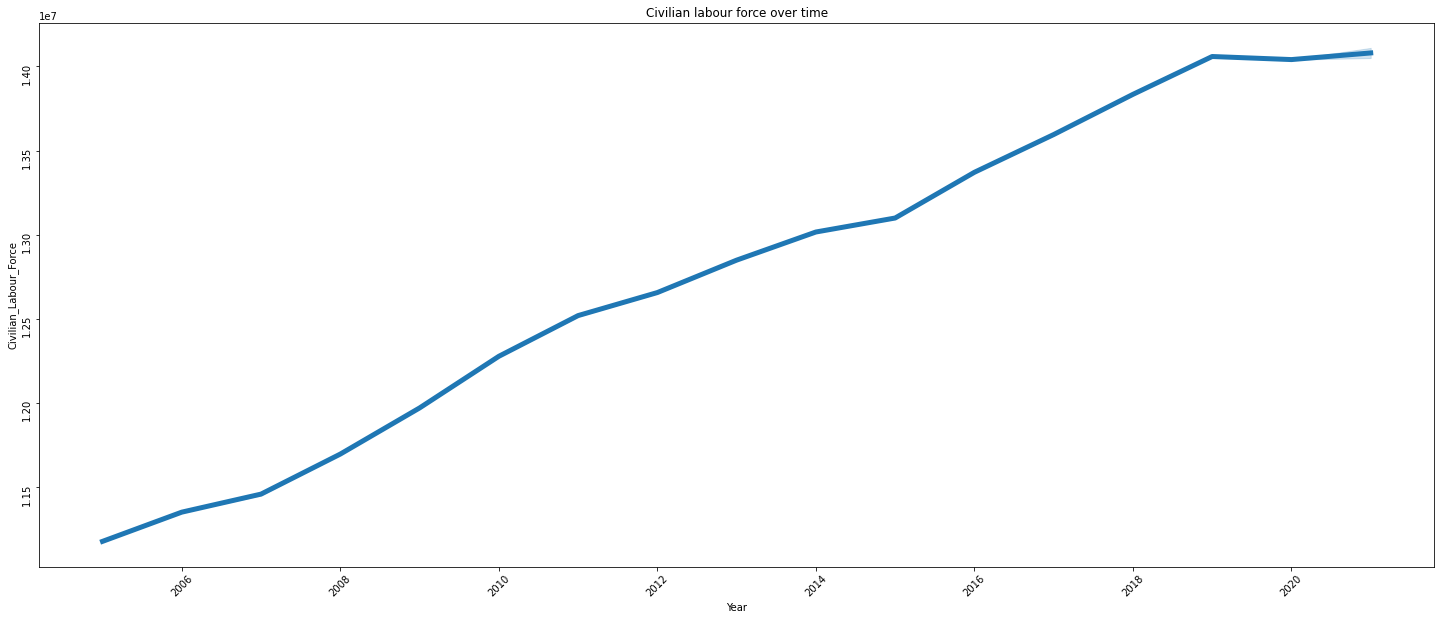

In [16]:
fig, ax=plt.subplots(figsize=(25,10))
sns.lineplot(data=tx_variation, x="Year", y="Civilian_Labour_Force", palette='icefire', linewidth=5)
ax.set_title('Civilian labour force over time')
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.show()

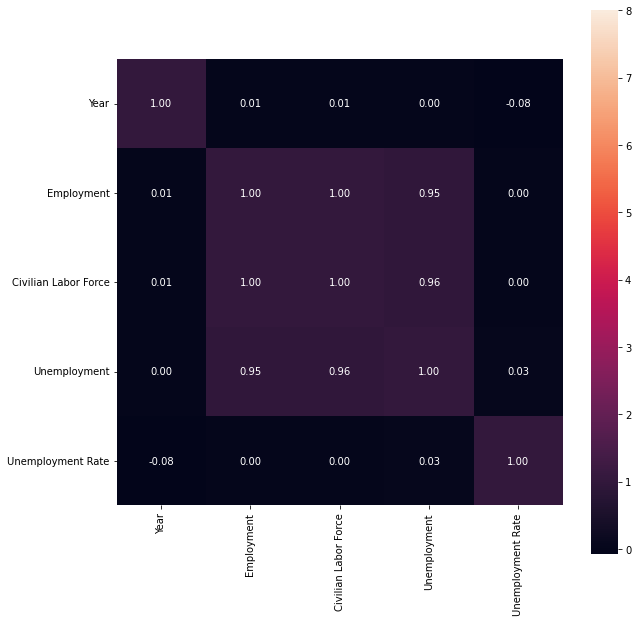

In [17]:
corrmatrix=df.corr()
fig, ax=plt.subplots(figsize=(10,10))
sns.heatmap(corrmatrix, vmax=8, square=True, annot=True, fmt='.2f')
plt.show()

**As we can see employment, civilian labor force and unemployment are highly correlate so will not add much value while model building**

In [18]:
tx1=tx_variation[tx_variation['Adjustment']=='Adjusted'].drop('Adjustment', axis=1)
tx2=tx_variation[tx_variation['Adjustment']=='Adjusted'].drop('Adjustment', axis=1)
for i in tx1.columns:
    tx1[i]=tx1[i]+tx2[i]
    tx1[i]=tx1[i]/2
tx1=tx1.reset_index(drop=True)    

In [19]:
dff2=pd.read_csv('../input/use-for-now/Strategic_Measure_Number_of_persons_experiencing_homelessness_-_Point_in_Time_Count.csv')

In [20]:
tx2=tx1[(tx1['Year']>=2010) & (tx1['Year']<=2020)]
tx2=tx2.reset_index(drop=True)
tx2 = pd.concat([tx2, dff2], axis=1, join='inner')
tx2=tx2.drop(['Difference from Previous Year','PIT Count Year'], axis=1)

# Testing a Base model

In [21]:
import numpy as np
import pandas as pd
import os
import datetime
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import random
import tensorflow as tf
import math
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn import linear_model, tree, ensemble
from xgboost import plot_importance
import optuna
from sklearn.metrics import mean_absolute_error as acc
import gc
from lightgbm import LGBMClassifier as lgb
from xgboost import XGBRegressor as clf
from scipy.stats import loguniform
from sklearn import linear_model, tree, ensemble
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier as cat
#import tensorflow_decision_forests as tfdf
import gc

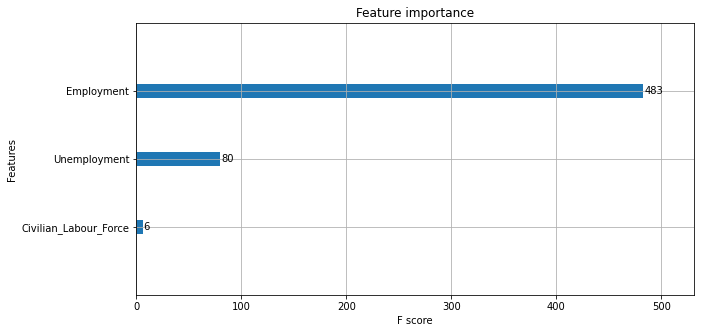

In [22]:
features=['Employment','Civilian_Labour_Force','Unemployment','Unemployment_rate']
X=tx2[features]
y=tx2['Unsheltered']
xgb_m = clf(n_estimators=1000, random_state=0)
xgb_m.fit(X,y)
pred=xgb_m.predict(X)
fig, ax=plt.subplots(figsize=(10,5))
plot_importance(xgb_m,ax=ax)
plt.show()

# EXtra EDA

In [23]:
def prepare_percentages(c):
    y=c['Year']
    c=c.drop('Year', axis=1)
    c=c.pct_change(fill_method ='ffill')
    final_list=[np.nan]
    for i in range(len(y)-1):
        final_list.append(str(int(y[i]))+'-'+str(int(y[i+1])))
    for i in c.columns:
        c[i]=c[i].apply(lambda x:x*100)
    c['Year']=final_list 
    c['Year']=c['Year'].fillna('Not_known')
    c=c.fillna(0)
    return c 

In [24]:
a=prepare_percentages(tx1)

In [25]:
def prepare_class(b,c):
    positiv=['Plus']*len(c)
    c['Class']=positiv
    c.loc[c[b] < 0, 'Class'] = "Minus"
    return c

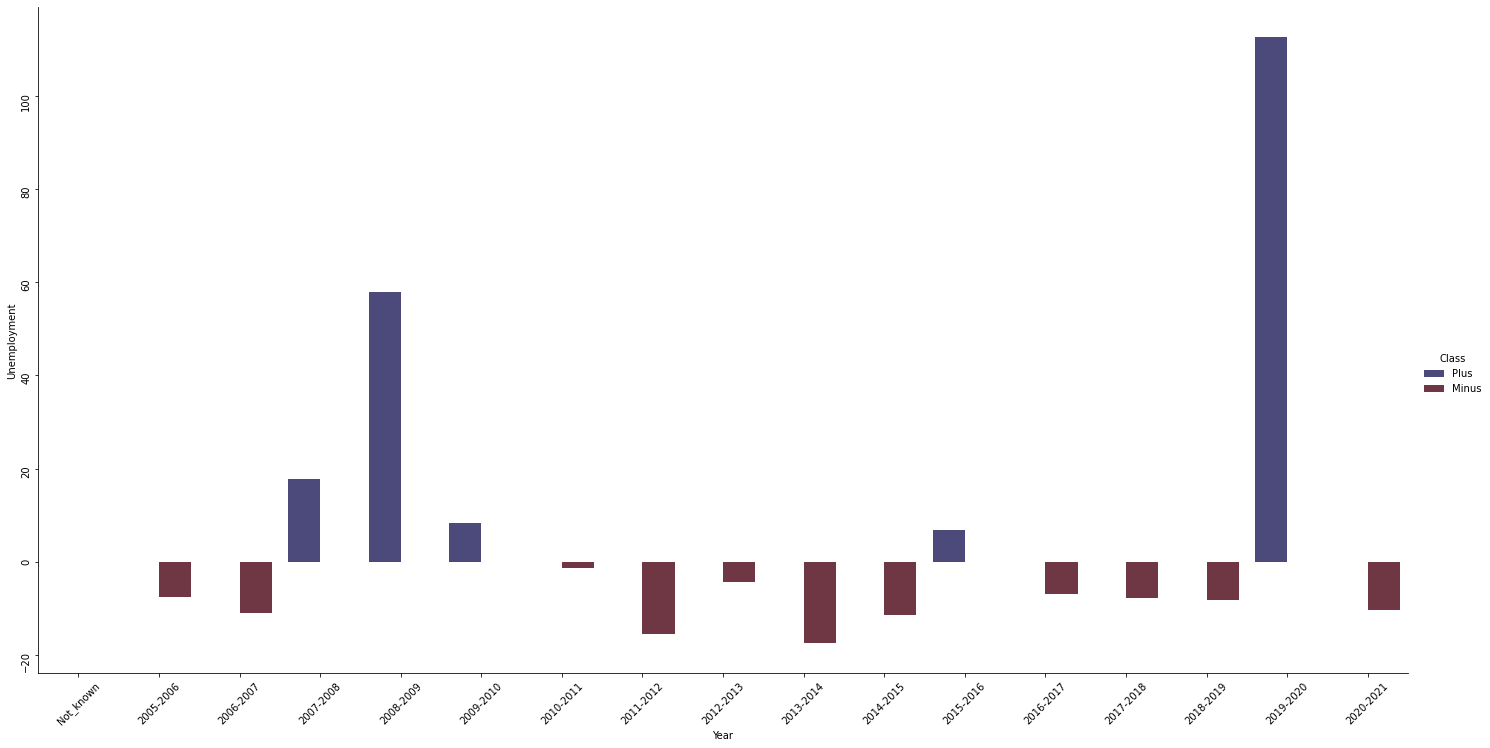

In [26]:
b=prepare_class('Unemployment_rate',a)
sns.catplot(x = 'Year', y = 'Unemployment', data = b, kind = 'bar',hue='Class', height=10, aspect=2,palette='icefire')
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.show()

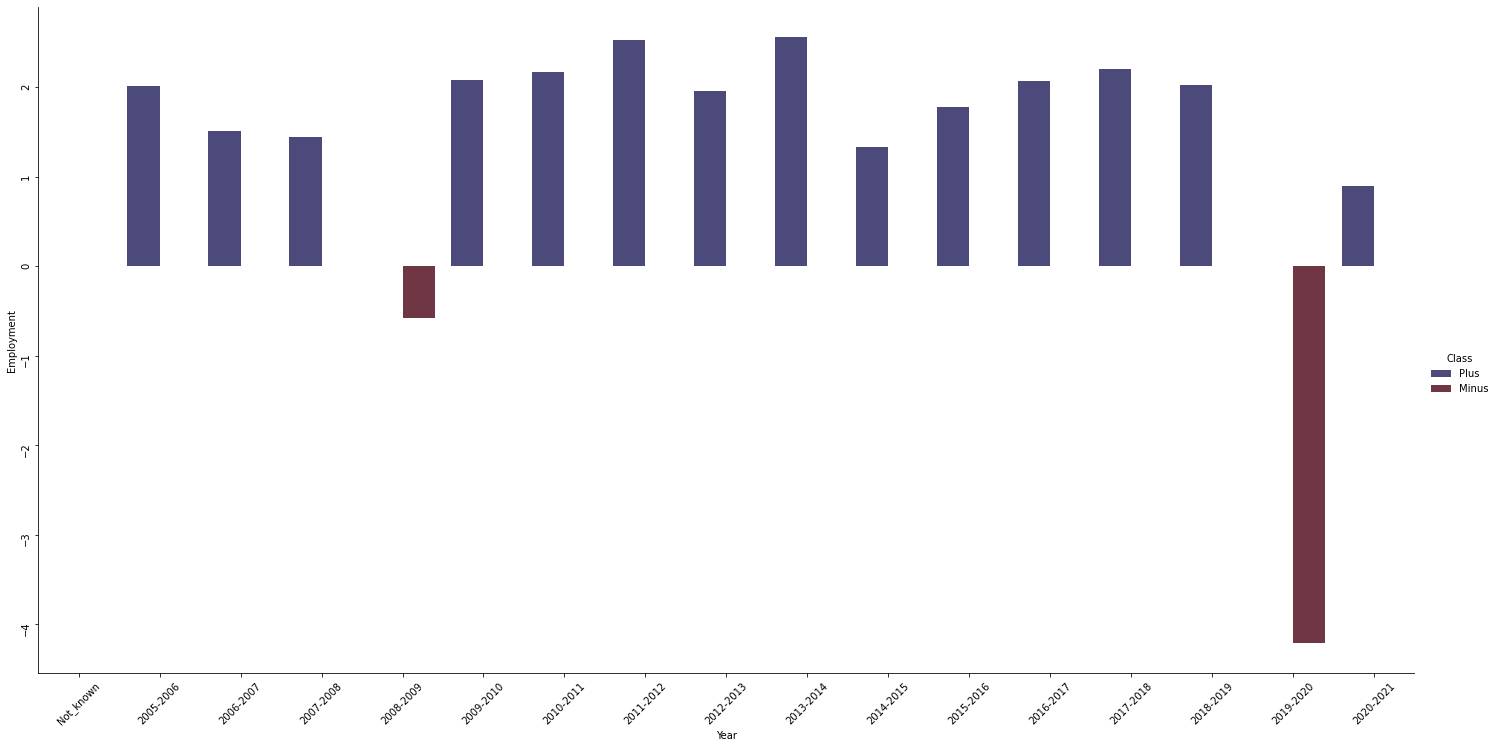

In [27]:
b=prepare_class('Employment',a)
sns.catplot(x = 'Year', y = 'Employment', data = a, kind = 'bar',hue='Class', height=10, aspect=2,palette='icefire')
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.show()

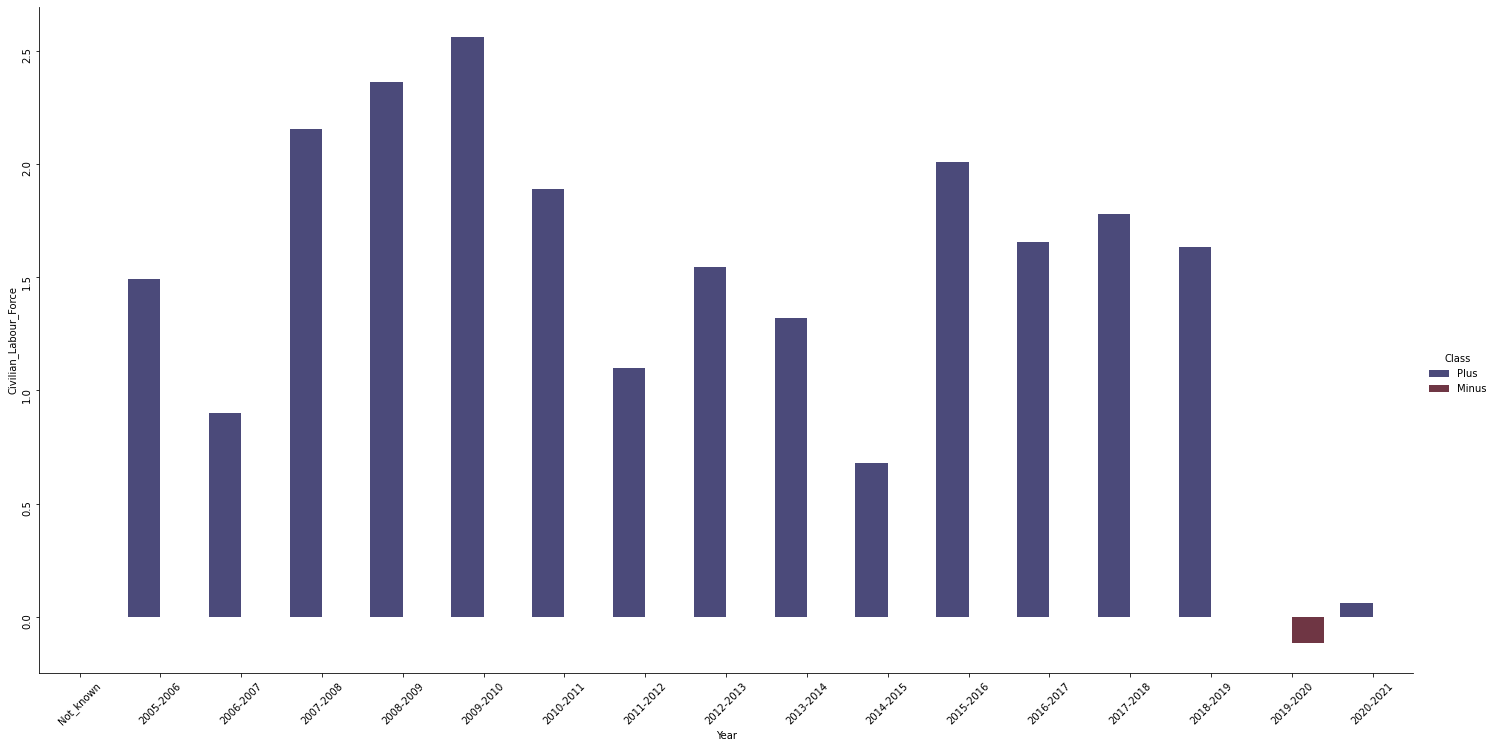

In [28]:
b=prepare_class('Civilian_Labour_Force',a)
sns.catplot(x = 'Year', y = 'Civilian_Labour_Force', data = a, kind = 'bar',hue='Class', height=10, aspect=2,palette='icefire')
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.show()

# nees : maybe data of cryptocurreny stock prices, population distribution among age groups over years
